In [ ]:
# -------------------------------

In [54]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import joblib

In [56]:
# Load the dataset
data = pd.read_csv('waterdata3.csv')
print(data.head())

         Date  Rainfall_Karnataka   Population_karnataka   
0  01-01-2013                36.44            62558000.0  \
1  15-01-2013                36.44            62584083.0   
2  01-02-2013                36.44            62610166.0   
3  15-02-2013                36.44            62636249.0   
4  01-03-2013                36.44            62662332.0   

   Consumption_karnataka  Reserved_Lake_karnataka   
0            14701.13000               2456.21898  \
1            14707.25951               2456.21898   
2            14713.38901               2456.21898   
3            14719.51852               2456.21898   
4            14725.64802               2456.21898   

   Reserved_Underground_karnataka  Rainfall_tamilnadu  Population_tamilnadu   
0                         3328.21              47.372            65287332.0  \
1                         3328.21              47.372            65313415.0   
2                         3328.21              47.372            65339498.0   
3   

In [57]:
# Check for missing values
print(data.isnull().sum())

# Convert non-numeric columns to numeric if possible, or drop them
for column in data.columns:
    if data[column].dtype == 'object':
        try:
            data[column] = pd.to_numeric(data[column])
        except ValueError:
            data = data.drop(columns=[column])

# Check for missing values again
print(data.isnull().sum())

Date                              7
Rainfall_Karnataka                7
Population_karnataka              7
Consumption_karnataka             7
Reserved_Lake_karnataka           7
Reserved_Underground_karnataka    7
Rainfall_tamilnadu                7
Population_tamilnadu              7
Consumption_tamilnadu             7
Reserved_Lake_tamilnadu           7
Reserved_Underground_tamilnadu    7
Distribution_State_karnataka      7
Distribution_State_tamilnadu      7
dtype: int64
Rainfall_Karnataka                7
Population_karnataka              7
Consumption_karnataka             7
Reserved_Lake_karnataka           7
Reserved_Underground_karnataka    7
Rainfall_tamilnadu                7
Population_tamilnadu              7
Consumption_tamilnadu             7
Reserved_Lake_tamilnadu           7
Reserved_Underground_tamilnadu    7
Distribution_State_karnataka      7
Distribution_State_tamilnadu      7
dtype: int64


In [58]:
# Fill NaNs with the mean of the column
data = data.fillna(data.mean())
print(data.isnull().sum())

Rainfall_Karnataka                0
Population_karnataka              0
Consumption_karnataka             0
Reserved_Lake_karnataka           0
Reserved_Underground_karnataka    0
Rainfall_tamilnadu                0
Population_tamilnadu              0
Consumption_tamilnadu             0
Reserved_Lake_tamilnadu           0
Reserved_Underground_tamilnadu    0
Distribution_State_karnataka      0
Distribution_State_tamilnadu      0
dtype: int64


In [59]:
# Assuming 'Date' is not needed for model training, drop it if it's still there
if 'Date' in data.columns:
    data = data.drop(columns=['Date'])

# Normalize the input features
input_features = data.drop(columns=['Distribution_State_karnataka', 'Distribution_State_tamilnadu'])
scaler = StandardScaler()
scaled_features = scaler.fit_transform(input_features)

# Check if the scaled features have any NaN values
print(np.isnan(scaled_features).sum())

# Prepare target variables
target = data[['Distribution_State_karnataka', 'Distribution_State_tamilnadu']].values

# Reshape input data for LSTM
scaled_features = scaled_features.reshape((scaled_features.shape[0], 1, scaled_features.shape[1]))

0


Epoch 1/50
7/7 [==============================] - 8s 275ms/step - loss: 0.2447 - val_loss: 0.2310
Epoch 2/50
7/7 [==============================] - 0s 17ms/step - loss: 0.2200 - val_loss: 0.2037
Epoch 3/50
7/7 [==============================] - 0s 15ms/step - loss: 0.1898 - val_loss: 0.1673
Epoch 4/50
7/7 [==============================] - 0s 14ms/step - loss: 0.1488 - val_loss: 0.1159
Epoch 5/50
7/7 [==============================] - 0s 13ms/step - loss: 0.0896 - val_loss: 0.0505
Epoch 6/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0342 - val_loss: 0.0130
Epoch 7/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0211 - val_loss: 0.0160
Epoch 8/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0206 - val_loss: 0.0072
Epoch 9/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0118 - val_loss: 0.0082
Epoch 10/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0122 - val_loss: 0.0061
Epoch 11/50
7/7 [===========

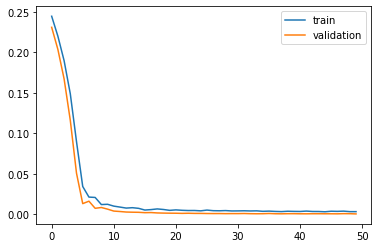

C:\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['scaler.pkl']

In [60]:

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled_features, target, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential([
    LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    Dropout(0.2),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(2)  # Output layer with 2 neurons for state 1 and state 2 predictions
])

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Fit the model and track the loss
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Plot the training and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

# Save the trained model
model.save('water_distribution_model.h5')
joblib.dump(scaler, 'scaler.pkl')

